In [147]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [148]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from matplotlib.colors import LogNorm, SymLogNorm

from itertools import chain

import pycharge_phase.pycharge as pc
from tqdm import tqdm

In [150]:
def latex_plot(font_size=9, width=330):
    fig_width_in = width / 72.27
    fig_height_in = fig_width_in * (5**.5-1)/2
    nice_fonts = {
        'text.usetex': True,
        'font.family': 'serif',
        'axes.labelsize': font_size,
        'font.size': font_size,
        'legend.fontsize': font_size,
        'xtick.labelsize': font_size,
        'ytick.labelsize': font_size,
        'figure.figsize': (fig_width_in, fig_height_in)
    }
    plt.style.use(nice_fonts)


latex_plot()

In [ ]:
from scipy.constants import e, mu_0, c

In [349]:
from numpy import linalg as LA


# Eigenstates from $H_\mathrm{eff}$

In [350]:
def Hij(rvec,μunit,k0):
    r=np.linalg.norm(rvec)
    x = k0*r
    μdotr = np.dot(μunit,rvec)/r
    μr2 = μdotr**2
    return (3/4)*( -(1-μr2) * np.exp(1j*x)/x + (1-3*μr2)/x**2 * np.exp(1j*x)*( -1j + 1/x ) )

# Dipole chain

Dipole-dipole distance 

$$ d = f \lambda = f \frac{2\pi}{k_0} = f \frac{2\pi\omega }{c} $$ 

In [516]:
Ndipoles = 11
nmax = Ndipoles//2
nmax

5

In [517]:
# let's put atomic positions in an array

f = 0.4/2
uf = 0.1/2

# consider a chain of atoms separated by distance a
k0 = 1.
λ0 = 2*np.pi/k0 # resonance wavelength
d = f*λ0

# ssh chain
u = uf*λ0

pos = [(i_dip)*d-u*np.cos(np.pi*(i_dip+nmax)) 
       for i_dip in range(-nmax,Ndipoles-nmax)]

np.array(pos)/λ0,np.diff(np.array(pos)/λ0), len(pos)

(array([-1.05, -0.75, -0.65, -0.35, -0.25,  0.05,  0.15,  0.45,  0.55,
         0.85,  0.95]),
 array([0.3, 0.1, 0.3, 0.1, 0.3, 0.1, 0.3, 0.1, 0.3, 0.1]),
 11)

In [518]:
μunit = np.array([1, 0, 0]) # unit direction of dipole moments
runit = np.array([1, 0, 0])

In [519]:
def get_Heff(pos,μunit,runit,k0):
    Natom = len(pos)
    λ0 = 2*np.pi/k0 # resonance wavelength
    
    Heff = np.zeros([Natom,Natom], dtype=complex)
    
    for i1 in range(Natom):
        Heff[i1,i1] = -1j/2
        for i2 in range(i1+1,Natom):
            rvec = np.abs(pos[i1]-pos[i2])*runit
            Heff[i1,i2] = Hij(rvec,μunit,k0)
            Heff[i2,i1] = Heff[i1,i2]
    return Heff

Heff = get_Heff(pos,μunit,runit,k0)

In [520]:
ee, uu = LA.eig(Heff)
idxsorted = np.argsort(ee.imag)
IPRs = Ndipoles*np.sum(abs(uu)**4,axis=0)

In [767]:
istate=-1
Estate=ee[idxsorted[istate]]
Estate

np.complex128(6.998467720698745-0.004378635414855836j)

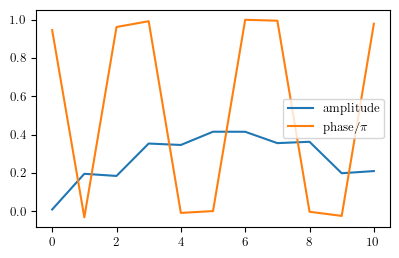

In [768]:
plt.plot(abs(uu[:,idxsorted[istate]]), label="amplitude")
plt.plot(np.angle(uu[:,idxsorted[istate]])/np.pi, label="phase/$\\pi$")
plt.legend();

In [769]:
amps = abs(uu[:,idxsorted[istate]])
phases = np.angle(uu[:,idxsorted[istate]])

# Classical dipole simulation

In [770]:
omega = 7e16
Γ0 = 0.1*omega
T0 = 2*np.pi/omega 
k0 = omega/c
λ0 = 2*np.pi*c/omega

d = f*λ0
u = uf*λ0

pos = [(i_dip)*d-u*np.cos(np.pi*(i_dip+nmax)) 
       for i_dip in range(-nmax,Ndipoles-nmax)]

d/λ0, λ*k0/(2*np.pi)

(0.2, 1.0)

In [771]:
2*np.pi/(-Estate.imag*Γ0)/T0

np.float64(2283.816543864784)

In [772]:
t=120*T0 # 2*Ndipoles*T0
tstop=None

#lim = float(f'{1.1*c*t+d*nmax:.2g}') #1000e-9
lim = ((1.1*c*t+d*nmax)//(λ0/2/np.pi))/k0
grid_size = 400
grid_spacing = 2*lim/λ0/grid_size

print(f"dx/λ= {grid_spacing:.3}")

coord = np.linspace(-lim, lim, grid_size)
x, y, z = np.meshgrid(coord, coord, 5.0*λ0, indexing='ij')

dx/λ= 0.664


In [773]:
np.diff( np.array(pos)/λ0 )

array([0.3, 0.1, 0.3, 0.1, 0.3, 0.1, 0.3, 0.1, 0.3, 0.1])

In [774]:
#amps = [1]*Ndipoles
#phases = [0]*Ndipoles
gammas = [-1*Estate.imag*Γ0]*Ndipoles
#gammas = [1/T0]*Ndipoles

In [775]:
d/10e-9

0.5381861620882438

In [776]:
amps=np.array(amps)
amps=amps/amps.max()*d/10 #2e-9

In [777]:
dipoles = [ [pc.OscillatingCharge((pos[i_dip+nmax], 0, 0), (+1, +0, 0), 
                                  amps[i_dip+nmax], omega=Estate.real*Γ0, phase=phases[i_dip+nmax], gamma=gammas[i_dip+nmax],
                                  q=+e, start_zero=True, stop_t=tstop),
             pc.OscillatingCharge((pos[i_dip+nmax], 0, 0), (+1, -0, 0),
                                  amps[i_dip+nmax], omega=Estate.real*Γ0, phase=phases[i_dip+nmax]+np.pi, gamma=gammas[i_dip+nmax],
                                  q=-e, start_zero=True, stop_t=tstop)]
             for i_dip in range(-nmax,Ndipoles-nmax)]

dipoles = list( chain.from_iterable(dipoles) )

simulation = pc.Simulation(dipoles)

Local pycharge running!


In [778]:
# Calculate E and B

def calculate_S(t,x,y,z):

    # Ex, Ey, _ = simulation.calculate_E(t, x, y, z, 'Acceleration')
    Ex, Ey, _ = simulation.calculate_E(t, x, y, z, 'Total')
    _, _, Bz = simulation.calculate_B(t, x, y, z, 'Total')
    
    Ex = Ex[:, :, 0]
    Ey = Ey[:, :, 0]
    Bz = Bz[:, :, 0]
    
    Sx = Ey*Bz
    Sy = -Ex*Bz
    S = (Sx**2+Sy**2)**0.5/mu_0
    return S, Sx, Sy

In [779]:
%%time 
S, Sx, Sy = calculate_S(t,x,y,z)

/home/subasi/work/graduation-project-1/codes(julia&python)/pycharge_phase/pycharge/charges.py:241: RuntimeWarning: overflow encountered in exp
  xpos = (self.direction[0]*self.amplitude*np.exp(-self.gamma*t)*np.cos(self.omega*t+self.phase)
/home/subasi/work/graduation-project-1/codes(julia&python)/pycharge_phase/pycharge/charges.py:253: RuntimeWarning: overflow encountered in exp
  ypos = (self.direction[1]*self.amplitude*np.exp(-self.gamma*t)*np.cos(self.omega*t+self.phase)
/home/subasi/work/graduation-project-1/codes(julia&python)/pycharge_phase/pycharge/charges.py:253: RuntimeWarning: invalid value encountered in multiply
  ypos = (self.direction[1]*self.amplitude*np.exp(-self.gamma*t)*np.cos(self.omega*t+self.phase)
/home/subasi/work/graduation-project-1/codes(julia&python)/pycharge_phase/pycharge/charges.py:264: RuntimeWarning: overflow encountered in exp
  zpos = (self.direction[2]*self.amplitude*np.exp(-self.gamma*t)*np.cos(self.omega*t+self.phase)
/home/subasi/work/graduation-p

CPU times: user 18.6 s, sys: 1.46 ms, total: 18.6 s
Wall time: 18.6 s


In [786]:
def plot_S(S,Sx,Sy):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xlabel('$k_0x$')
    ax.set_ylabel('$k_0y$')
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    im = plt.imshow(S.T+S.max()/1000, origin='lower',
                    extent=[-lim, lim, -lim, lim], vmax=7)
    plt.xticks([-lim, -lim/2, 0, lim/2, lim], [f"{-lim*k0:.4g}", f"{-lim*k0/2:.4g}", 0, f"{lim*k0/2:.4g}", f"{lim*k0:.4g}"])
    plt.yticks([-lim, -lim/2, 0, lim/2, lim], [f"{-lim*k0:.4g}", f"{-lim*k0/2:.4g}", 0, f"{lim*k0/2:.4g}", f"{lim*k0:.4g}"])
    #im.set_norm(mpl.colors.LogNorm(vmin=Smin, vmax=Smax))
    im.set_norm(mpl.colors.LogNorm(vmin=S.max()/1000, vmax=2*S.max()))

    grid_size_quiver = grid_size
    x_quiver, y_quiver, z_quiver = np.meshgrid(
    np.linspace(-lim, lim, grid_size_quiver), np.linspace(-lim, lim, grid_size_quiver), 0, indexing='ij')
    #Q = ax.quiver(x_quiver, y_quiver, Sx, Sy, scale_units='xy',scale=10*S.max())
    #Q = ax.quiver(x_quiver, y_quiver, Sx, Sy, scale_units='xy')
    
    cb = fig.colorbar(im, fraction=0.046, pad=0.04)
    cb.ax.set_ylabel(r'$|\mathbf{S}|$ (W/$\mathrm{m}^2$)',
                     rotation=270, labelpad=12)
    for i_dip in range(-nmax,nmax+1):
        ax.scatter(i_dip*d, 0, s=30, c='red', marker="_")
        #ax.scatter(i_dip*d, 0, s=30, c='red', marker="|")
        #ax.scatter(i_dip*d, -d/3, s=10, c='red', marker=7)
    #ax.scatter(+nmax*d, 0, s=2, c='red', marker='o')
    return

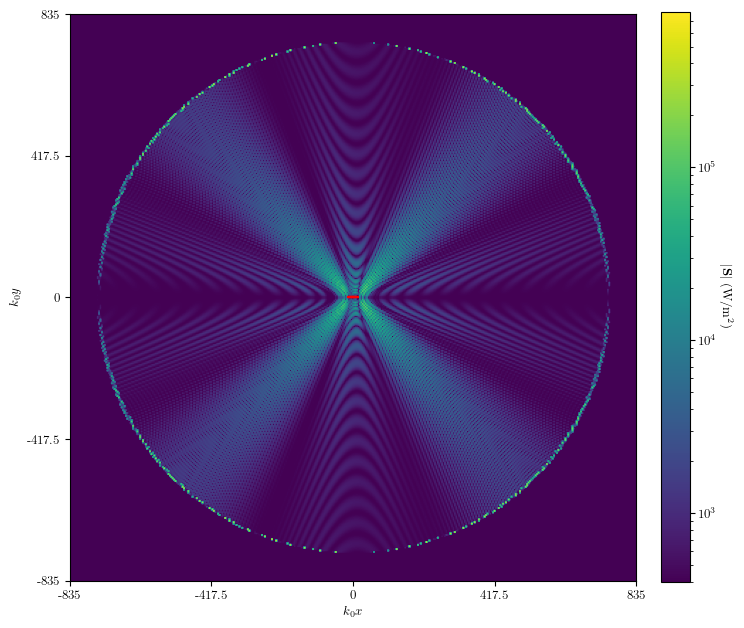

In [787]:
plot_S(S,Sx,Sy)

In [500]:
Slist=[]

tlist = t+np.linspace(0, 2*np.pi/omega, 41)

for t in tqdm(tlist):
    S, Sx, Sy = calculate_S(t,x,y,z)
    Slist.append([S, Sx, Sy])

Slist=np.array(Slist)

  0%|                                                                                                                                             | 0/41 [00:00<?, ?it/s]/home/subasi/work/graduation-project-1/codes(julia&python)/pycharge_phase/pycharge/charges.py:241: RuntimeWarning: overflow encountered in exp
  xpos = (self.direction[0]*self.amplitude*np.exp(-self.gamma*t)*np.cos(self.omega*t+self.phase)
/home/subasi/work/graduation-project-1/codes(julia&python)/pycharge_phase/pycharge/charges.py:252: RuntimeWarning: overflow encountered in exp
  ypos = (self.direction[1]*self.amplitude*np.exp(-self.gamma*t)*np.cos(self.omega*t+self.phase)
/home/subasi/work/graduation-project-1/codes(julia&python)/pycharge_phase/pycharge/charges.py:252: RuntimeWarning: invalid value encountered in multiply
  ypos = (self.direction[1]*self.amplitude*np.exp(-self.gamma*t)*np.cos(self.omega*t+self.phase)
/home/subasi/work/graduation-project-1/codes(julia&python)/pycharge_phase/pycharge/charges.py:263: Ru

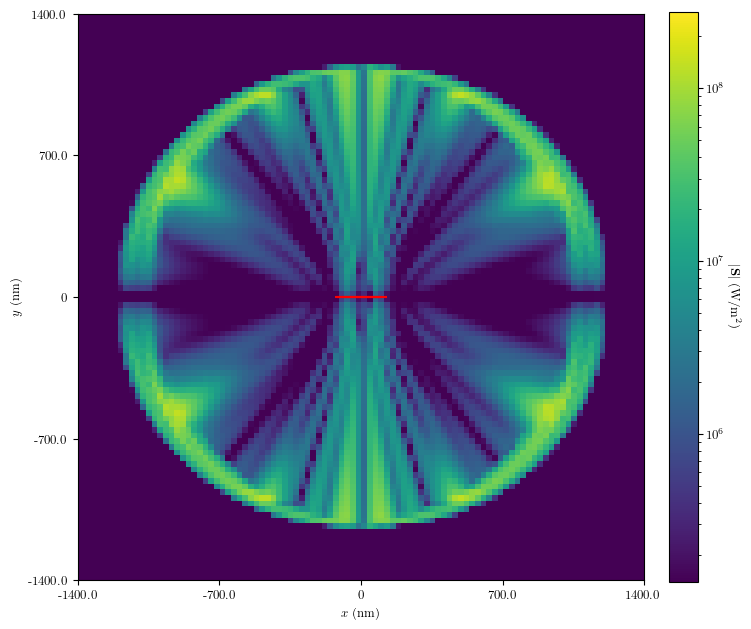

In [501]:
plot_S(np.average(Slist[:,0,:,:],axis=0),np.average(Slist[:,1,:,:],axis=0),np.average(Slist[:,2,:,:],axis=0))

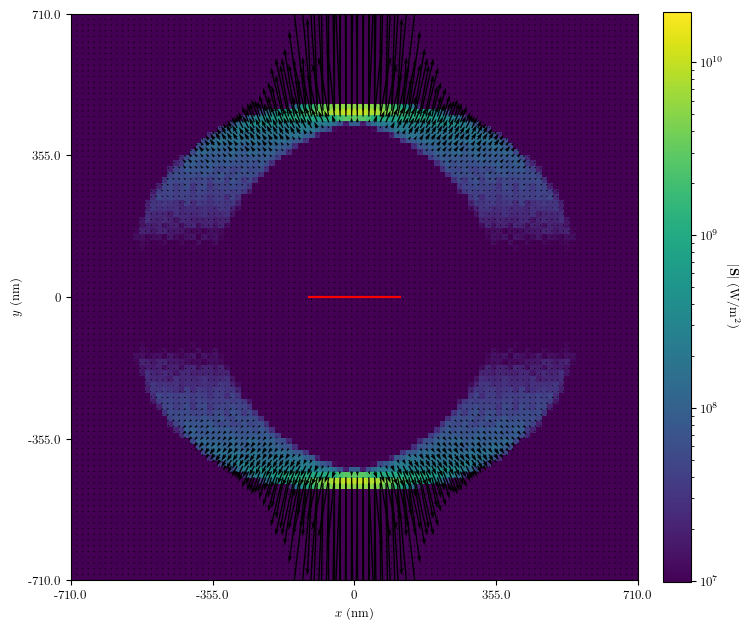

In [140]:
plot_S(np.average(Slist[:,0,:,:],axis=0),np.average(Slist[:,1,:,:],axis=0),np.average(Slist[:,2,:,:],axis=0))